In [1]:
import numpy as np
import faiss
from openai import AzureOpenAI
import re
from IPython.display import Image as IpyImage, display
import re
import os
import base64
import io
from PIL import Image


In [60]:

def query_vector_index(index, query_embedding, k=5):
    """Query the FAISS index to find the k most similar items."""
    # Search the index
    distances, indices = index.search(np.array([query_embedding]).astype('float32'), k)
    return indices[0]

def construct_prompt(retrieved_texts, question):
    """Build a prompt to pass to the GPT-4 model."""

    context = "\n\n".join(retrieved_texts)
    return {
        "role": "system",
        "content": f"If there are image placeholders in the context like: '[Image: page_x_img_y.jpeg]', You need to integrate the image placeholder seamlessly in your text-based answer if the content of image is meaningful. \n\nContext:\n{context}\n\nQuestion: {question}"

    }

def construct_image_prompt(retrieved_texts, image_dir):
    """Search for image placeholders, process images, and return an array of image objects."""

    image_objects = []
    image_regex = r'\[Image: (.+?)\]'

    for text in retrieved_texts:
        matches = re.findall(image_regex, text)

        for file_name in matches:
            full_name = os.path.join(image_dir, file_name)
            if os.path.exists(full_name):
                # Open the image file, resize it, and convert to base64
                with Image.open(full_name) as img:
                    # Resize the image to 224x224
                    img_resized = img.resize((224, 224))
                    
                    # Convert image to JPEG and encode to base64
                    buffered = io.BytesIO()
                    img_resized.save(buffered, format="JPEG")
                    encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
                    
                    # Create image object
                    image_object = {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": f"[image: {file_name}]"},
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{encoded_image}"
                                },
                            },
                        ]
                    }
                    image_objects.append(image_object)
            else:
                print(f"Warning: Image file {file_name} not found.")
    
    return image_objects


def query_openai(messages, client):
    """Query the Azure OpenAI GPT-4 model with a constructed prompt."""
    response = client.chat.completions.create(
        model="AA-gpt4-o",
        messages=messages,
        stream=False,
        max_tokens=512,  # Adjust depending on desired length and model limits
        temperature=0,  # Adjust depending on desired creativity
        top_p=0,
        seed=42

    )
    return response.choices[0].message.content.strip()

# Initialize Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint="https://msec-cognitive-sb-eval02-oai.openai.azure.com", 
    api_key="d3116cc2cd9c47fda7474f67aa272385",  
    api_version="2024-02-01",
    timeout=300
)


def multi_rag_pipeline(question, text_file_name, index_name, image_dir):
    # Convert the question into an embedding
    # For now, you can use a simple embedding model; here, it's assumed as a dummy embedding
    response = client.embeddings.create(model="AA-text-embedding-3-large", input=question)

    question_embedding = response.data[0].embedding
    # Load the FAISS index
    index = faiss.read_index(index_name)

    # Assume you have a dictionary of documents
    with open(text_file_name, 'r') as file:
        # read the contents of the file
        contents = file.read()
        # print the contents to the screen
        
    documents = [x.strip() for x in contents.split('--- Page Break ---')]

    # Query the vector index
    relevant_indices = query_vector_index(index, question_embedding)

    # Retrieve relevant documents
    retrieved_texts = [documents[i] for i in relevant_indices]
    print('Retrived Texts:', retrieved_texts)

    system_message = construct_prompt(retrieved_texts, question)
    system_image_messages = construct_image_prompt(retrieved_texts, image_dir)
    print('System Image Messages:', system_image_messages)
    user_message = {"role": "user", "content": question}
    messages = [system_message, *system_image_messages, user_message]

    # Query GPT-4
    response = query_openai(messages, client)

    return response


In [ ]:


def resize_image(image_path, max_size=(400, 400)):
    with Image.open(image_path) as img:
        img.thumbnail(max_size)
        buf = io.BytesIO()
        img.save(buf, format='PNG')
        return buf.getvalue()

def display_text_and_images(text, image_folder="./images", max_size=(400, 400)):
    # Define the patterns for various image reference formats
    image_placeholder_pattern = (
        r'!\[.*?\]\(attachment://(page_\d+_img_\d+\.(?:png|jpg|jpeg))\)|'  # ![Description](attachment://...)
        r'!\[.*?\]\((page_\d+_img_\d+\.(?:png|jpg|jpeg))\)|'              # ![Description](...)
        r'\[Image: (page_\d+_img_\d+\.(?:png|jpg|jpeg))\]'               # [Image: ...]
    )
    
    # Split the text at image placeholders
    # Using capture groups to keep the delimiters in the result
    parts = re.split(f'({image_placeholder_pattern})', text)

    # Iterate through the parts and process text/image sections
    for part in parts:
        if not part:
            continue
        
        # Check if the part is an image placeholder
        img_match = re.match(image_placeholder_pattern, part)
        if img_match:
            # Extract image filename from match groups
            image_filename = next(filter(None, img_match.groups()))
            image_path = os.path.join(image_folder, image_filename)
            
            if os.path.exists(image_path):
                try:
                    #print(f"[Displaying image: {image_filename}]")
                    img_data = resize_image(image_path, max_size)
                    display(IpyImage(data=img_data))
                except Exception as e:
                    print(f"Error displaying image {image_filename}: {str(e)}")
            else:
                print(f"Image not found: {image_filename}")
        else:
            # Display text part
            #pass
            print(part.strip())



Retrived Texts: ['PART II Item 5. Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities Shareholder information The primary exchange market for Autoliv’s securities is the New York Stock Exchange (NYSE) where Autoliv’s common stock trades under the symbol “ALV”. Autoliv’s Swedish Depositary Receipts (SDRs) are traded on NASDAQ Stockholm’s list for large market cap companies under the symbol “ALIV SDB”. Options in SDRs trade on Nasdaq Stockholm under the name “Autoliv SDB”. Options in Autoliv shares are traded on NASDAQ OMX PHLX and on NYSE Amex Options under the symbol “ALV”. Stock Performance Graph The graph and table below show the cumulative total shareholder return for our common stock since December 31, 2018. The graph compares our performance to that of the Standard & Poor’s 500 Stock Index (S&P 500) and the Dow Jones US Auto Parts Index. The comparison assumes $100 was invested at the closing price of our common stock on the
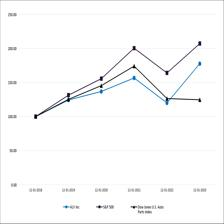

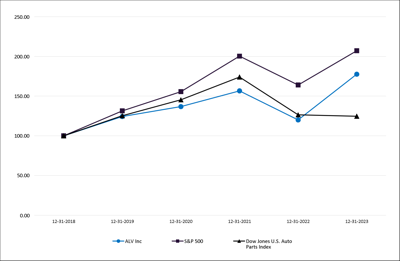

In [101]:

# Example question
question = "What is the stock performance of Autoliv in 2023? Show images if applicable."

# Run the RAG pipeline
answer = multi_rag_pipeline(question, 'output-alv.txt', 'faiss_index-alv.index', 'images-alv')
# Process and display the text with images77070
display_text_and_images(answer)


In [98]:
print(answer)

In 2023, Autoliv's stock performance showed a cumulative total shareholder return of $177.63, starting from a base of $100 on December 31, 2018. This performance is compared to the S&P 500, which reached $207.21, and the Dow Jones US Auto Parts Index, which was at $124.70.

Here's the stock performance graph for visual reference:

![Stock Performance Graph](page_101_img_1.jpeg)


Retrived Texts: ['[Image: page_3_img_1.png] Figure 1: The Transformer - model architecture. The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of [Image: page_3_img_1.png] Figure 1, respectively. 3.1 Encoder and Decoder Stacks N = 6 The encoder is composed of a stack of identical layers. Each layer has two Encoder: sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position- wise fully connected feed-forward network. We employ a residual connection [11] around each of the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x) Sublayer(x)), where is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding = layers, produce outputs of dimension 512. dmodel N = 6 
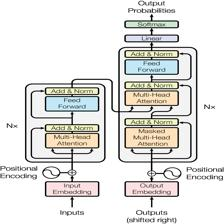
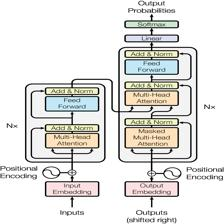
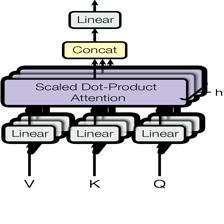
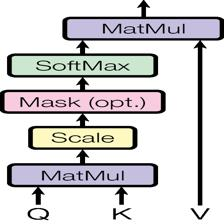
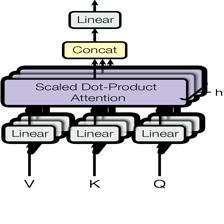
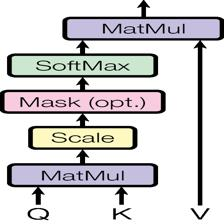
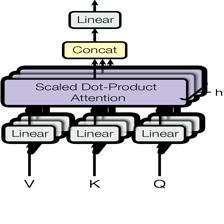
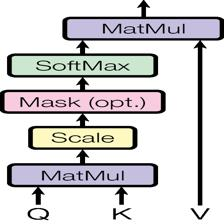
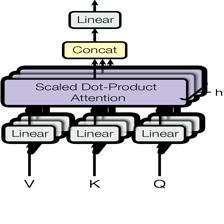
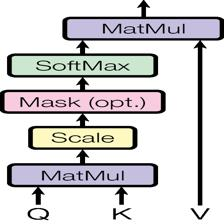

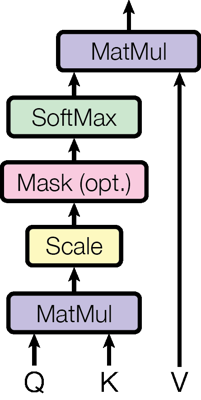

page_4_img_1.png
3. **Multi-Head Attention**:
   - Instead of performing a single attention function, the model uses multiple attention heads. Each head processes a different linear projection of Q, K, and V.
   - The outputs of these heads are concatenated and linearly transformed to produce the final output.


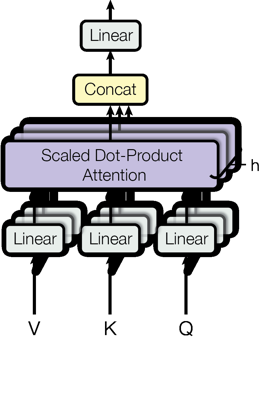

page_4_img_2.png
### Transformer Architecture

- **Encoder**: Consists of multiple identical layers, each with two sub-layers: multi-head self-attention and a feed-forward neural network. Residual connections and layer normalization are applied around each sub-layer.

- **Decoder**: Similar to the encoder but includes a third sub-layer for encoder-decoder attention, allowing the decoder to focus on relevant parts of the input sequence.


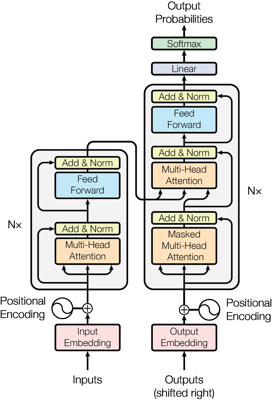

page_3_img_1.png
### Key Features

- **Parallelization**: Unlike RNNs, self-attention allows for parallel processing of sequence elements, improving efficiency.
- **Long-Range Dependencies**: Self-attention can capture dependencies between distant elements in the sequence, which is crucial for tasks like translation.

This architecture is foundational for many modern NLP models, enabling them to handle complex sequence transduction tasks effectively.


In [99]:
# Example question
question = "Explain the self-attention architecture, Show images if applicable."

# Run the RAG pipeline
answer = multi_rag_pipeline(question, 'output_processed.txt', 'faiss_index_attention_is_all_you_need.index', 'images')

display_text_and_images(answer, 'images')

In [91]:
print(answer)

The self-attention architecture is a key component of the Transformer model, which allows it to process sequences of data efficiently by focusing on different parts of the input sequence. Here's a breakdown of how it works:

### Self-Attention Mechanism

1. **Inputs**: The mechanism takes three inputs: Queries (Q), Keys (K), and Values (V). These are derived from the input embeddings.

2. **Scaled Dot-Product Attention**:
   - **Dot Product**: Compute the dot product of the query with all keys to get the raw attention scores.
   - **Scale**: Divide the scores by the square root of the dimension of the keys to stabilize gradients.
   - **Mask (Optional)**: Apply a mask to prevent attending to certain positions, useful in the decoder to prevent looking ahead.
   - **Softmax**: Apply the softmax function to obtain the attention weights.
   - **Weighted Sum**: Multiply the attention weights with the values to get the output.

   ![Scaled Dot-Product Attention](attachment://page_4_img_1.png